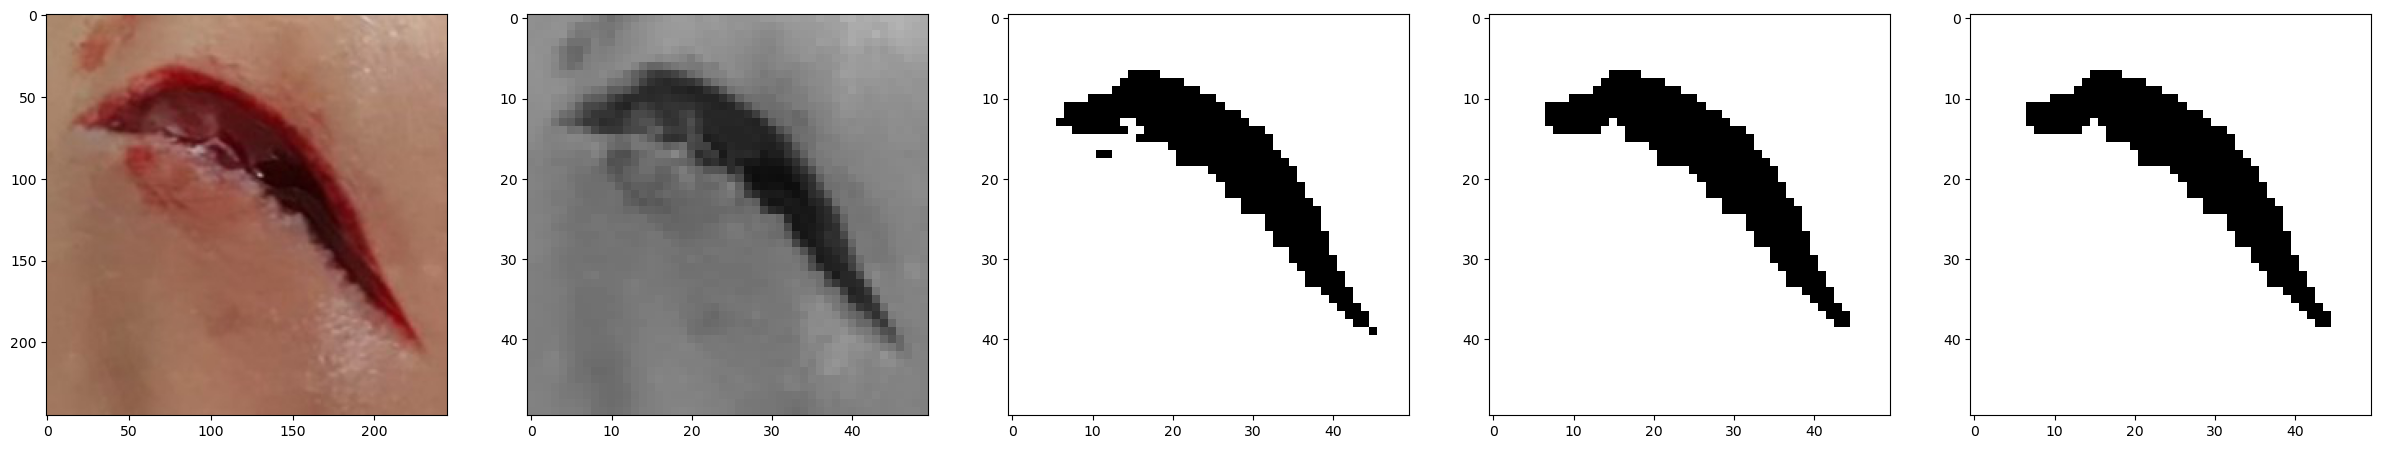

In [3]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

def plot_five_images(img1: np.array, img2: np.array, img3: np.array, img4: np.array, img5: np.array):
    _, ax = plt.subplots(1, 5, figsize=(30, 6))  #4 subplots
    ax[0].imshow(img1, cmap='gray', vmin=0, vmax=255) #original colour range
    ax[1].imshow(img2, cmap='gray', vmin=0, vmax=255)
    ax[2].imshow(img3, cmap='gray', vmin=0, vmax=1)
    ax[3].imshow(img4, cmap='gray', vmin=0, vmax=1)
    ax[4].imshow(img5, cmap='gray', vmin=0, vmax=1)
    plt.show()

img_raw = Image.open('cut1.jpg')
img_grayscale = ImageOps.grayscale(img_raw)
img_grayscale = img_grayscale.resize(size=(50, 50))

def black_and_white(img: np.array) -> np.array:
    min=np.min(img)
    max=np.max(img)
    y_len, x_len = img.shape #x_len: no. of columns; y_len: no. of rows

    # 2D array of zeros
    new_img = np.zeros(shape=(y_len, x_len))

    # Iterate over the rows
    for y in range(y_len):
        # Iterate over the columns
        for x in range(x_len):
            # img[y, x] = individual pixel value
            if img[y,x] <= (min+max)*0.5*(5/6):
                new_img[y,x] = 0
                #print(f'{y,x}')
            else:
                new_img[y,x] = 1

    return new_img

def clean_isolated_pixels(img: np.array) -> np.array:
    # Ensure we work with a binary image (0/1)
    #img = (img > 0).astype(np.uint8)
    #print(img[7,18])
    y_len, x_len = img.shape
    cleaned_img = img.copy()
    #print(cleaned_img[7,18])
    for y in range(1, y_len-1):
        for x in range(1, x_len-1):
            neighborhood = img[y-1:y+2, x-1:x+2] #excludes stop index
            neighbor_count = np.sum(neighborhood) - img[y, x]
            if img[y, x] == 1 and neighbor_count <= 2:
                # Pixel is ON, but too few ON neighbors -> likely isolated
                cleaned_img[y, x] = 0
            elif img[y, x] == 0 and neighbor_count >= 6:
                # Pixel is OFF, but surrounded by ON pixels -> likely noise hole
                cleaned_img[y, x] = 1

    return cleaned_img

def keep_largest_zero_patch(img):
    """
    Given a 2D array of 1s and 0s, find all patches of 0s (connected components),
    identify the largest patch, and set all smaller patches to 1.

    Args:
        grid: 2D list of 1s and 0s

    Returns:
        Modified grid with only the largest zero patch remaining
    """
    cleaned_img_v2 = img.copy()
    rows, cols = img.shape
    visited = [[False] * cols for _ in range(rows)]
    patches = []  # List of (area, cells_list)

    def flood_fill(start_r, start_c):
        """Iterative BFS/DFS to find all cells in a connected patch of zeros"""
        stack = [(start_r, start_c)]
        cells = []

        while stack:
            r, c = stack.pop()

            # Skip if out of bounds, already visited, or not a zero
            if (r < 0 or r >= rows or c < 0 or c >= cols or
                visited[r][c] or img[r][c] == 1):
                continue

            visited[r][c] = True
            cells.append((r, c))

            # Add all 4 neighbors to stack
            stack.append((r + 1, c))
            stack.append((r - 1, c))
            stack.append((r, c + 1))
            stack.append((r, c - 1))

        return cells

    # Find all patches of zeros
    for y in range(rows):
        for x in range(cols):
            if img[y][x] == 0 and not visited[y][x]:
                patch_of_zero = flood_fill(y, x)
                patches.append((len(patch_of_zero), patch_of_zero)) #(size of patch, all cells in patch)

    # If no patches found, return original grid
    if not patches:
        return cleaned_img_v2

    # Find the largest patch
    largest_patch = max(patches, key=lambda x: x[0])
    largest_cells = largest_patch[1]

    # Change all zeros not in the largest patch to 1
    for i in range(rows):
        for j in range(cols):
            if img[i][j] == 0 and (i, j) not in largest_cells:
                cleaned_img_v2[i][j] = 1

    return cleaned_img_v2

img_btw = black_and_white(np.array(img_grayscale))
img_cleaned = clean_isolated_pixels(img_btw)
img_final = keep_largest_zero_patch(img_cleaned)

plot_five_images(
    img1=img_raw,
    img2=img_grayscale,
    img3=img_btw,
    img4=img_cleaned,
    img5=img_final
)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
A = 1.0      # Contact inhibition constant
X = 50.0      # Total simulation length (x-axis)
Y = 50.0      # Total simulation lenght (y-axis)
T = 1.0      # Total simulation duration
nx = 50      # Number of spatial points (x-axis)
ny = 50      # Number of spatial points (y-axis)
nt = 1000    # Number of time steps

dx = X / (nx - 1)
dy = Y / (ny - 1)
dt = T / nt

# Spatial and temporal grids
x = np.linspace(0, X, nx)
y = np.linspace(0, Y, ny)
t = np.linspace(0, T, nt)

# Initialise solution array
u = np.zeros((nt, nx, ny))

# Initial condition
#u[0, :, :] = np.array([[max(abs(2*x/X-1), abs(2*y/Y-1)) for x in x] for y in y])
u[0, :, :] = img_final

# Boundary conditions (fixed at one)
u[:, 0, :] = 1
u[:, -1, :] = 1
u[:, :, 0] = 1
u[:, :, -1] = 1

# Time integration using Explicit Euler
for n in range(nt - 1):
    for i in range(1, nx - 1):
        for j in range(1, ny - 1):
            du_dx = (u[n, i+1, j] - u[n, i, j]) / dx
            du_dy = (u[n, i, j+1] - u[n, i, j]) / dy
            # Finite difference approximation of the second spatial derivative
            d2u_dx2 = (u[n, i+1, j] - 2 * u[n, i, j] + u[n, i-1, j]) / dx**2
            d2u_dy2 = (u[n, i, j+1] - 2 * u[n, i, j] + u[n, i, j-1]) / dy**2
            # Explicit Euler update
            u[n+1, i, j] = u[n, i, j] + (
                -A*(A+u[n, i, j])**(-2)*(du_dx)**2 + A/(A+u[n, i, j])*d2u_dx2 + 
                -A*(A+u[n, i, j])**(-2)*(du_dy)**2 + A/(A+u[n, i, j])*d2u_dy2 + 
                u[n, i, j]*(1-u[n, i, j]))*dt

print(u)

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 ...

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]


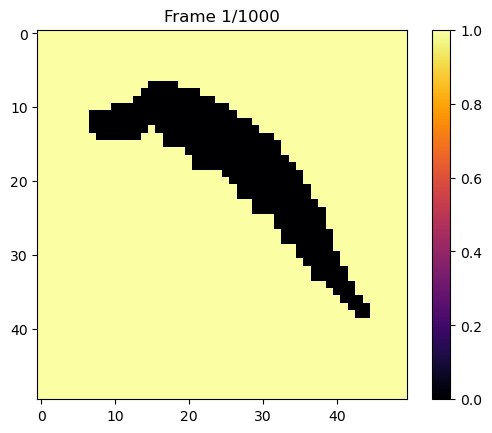

ValueError: unknown file extension: .gif1

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Initialize figure and heatmap
fig, ax = plt.subplots()
heatmap = ax.imshow(u[0], cmap='inferno', interpolation='nearest', animated=True)
fig.colorbar(heatmap)

# Update function for animation
def update(frame):
    heatmap.set_array(u[frame])
    ax.set_title(f"Frame {frame+1}/{u.shape[0]}")
    return [heatmap]

# Create the animation
ani = FuncAnimation(
    fig, update, frames=u.shape[0], interval=10, blit=True
)

plt.show()
ani.save('animation.gif1', writer='pillow')